In [100]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
import mygene
%matplotlib inline
import pickle
import sklearn
import random
import scanpy as sc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
from pathlib import Path
np.random.seed(202310)
# use hnswlib for NN classification
try:
    import hnswlib
    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print("hnswlib not installed! We highly recommend installing it for fast similarity search.")
    print("To install it, run: pip install hnswlib")
from scipy.stats import mode

### Load sampled Aorta data, available at https://drive.google.com/drive/folders/1LgFvJqWNq9BqHbuxB2tYf62kXs9KqL4t?usp=share_link

In [ ]:
sampled_adata = sc.read_h5ad("./datasets/aorta/sample_aorta_data_updated.h5ad")

/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [102]:
mapping_dict_phenotype = {
 'affected_1': 'Ascending only',
 'affected_2': 'Ascending only',
 'affected_3': 'Ascending w/ root',
 'affected_4': 'Ascending only',
 'affected_5': 'Ascending w/ root',
 'affected_6': 'Ascending to descending',
 'affected_7': 'Ascending w/ root',
 'affected_8': 'Ascending w/ root',
 'control_1':'Control',
 'control_2':'Control',
 'control_3':'Control'
}
sampled_adata.obs['phenotype'] = sampled_adata.obs.patient.map(mapping_dict_phenotype)

### Use GenePT-w embeddings for GenePT-s analyses
We compute GenePT-w (gene-level) embeddings and reuse them wherever GenePT-s cell embeddings are expected.

In [103]:
GENE_EMBED_PATH = Path("./embeddings/GenePT_embedding_v2/GenePT_gene_embedding_ada_text.pickle")

with open(GENE_EMBED_PATH, "rb") as fp:
    GPT_3_5_gene_embeddings = pickle.load(fp)

gene_names = list(sampled_adata.var.index)
count_missing = 0
EMBED_DIM = 1536  # embedding dim from GPT-3.5
lookup_embed = np.zeros(shape=(len(gene_names), EMBED_DIM))
for i, gene in enumerate(gene_names):
    if gene in GPT_3_5_gene_embeddings:
        embed = np.asarray(GPT_3_5_gene_embeddings[gene], dtype=float).flatten()
        if embed.shape[0] != EMBED_DIM:
            raise ValueError(
                f"Unexpected embedding size for {gene}: {embed.shape[0]} (expected {EMBED_DIM})"
            )
        lookup_embed[i, :] = embed
    else:
        count_missing += 1

genePT_w_emebed = np.dot(sampled_adata.X, lookup_embed) / len(gene_names)
print(f"Unable to match {count_missing} out of {len(gene_names)} genes in the GenePT-w embedding")

# Reuse GenePT-w embeddings for the GenePT-s analysis blocks below
sampled_cell_aorta_gpt = np.asarray(genePT_w_emebed, dtype=np.float32)

Unable to match 5344 out of 23331 genes in the GenePT-w embedding


### UMAP visualizations by phenotype, cell type, and patient id

/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul

([], [])

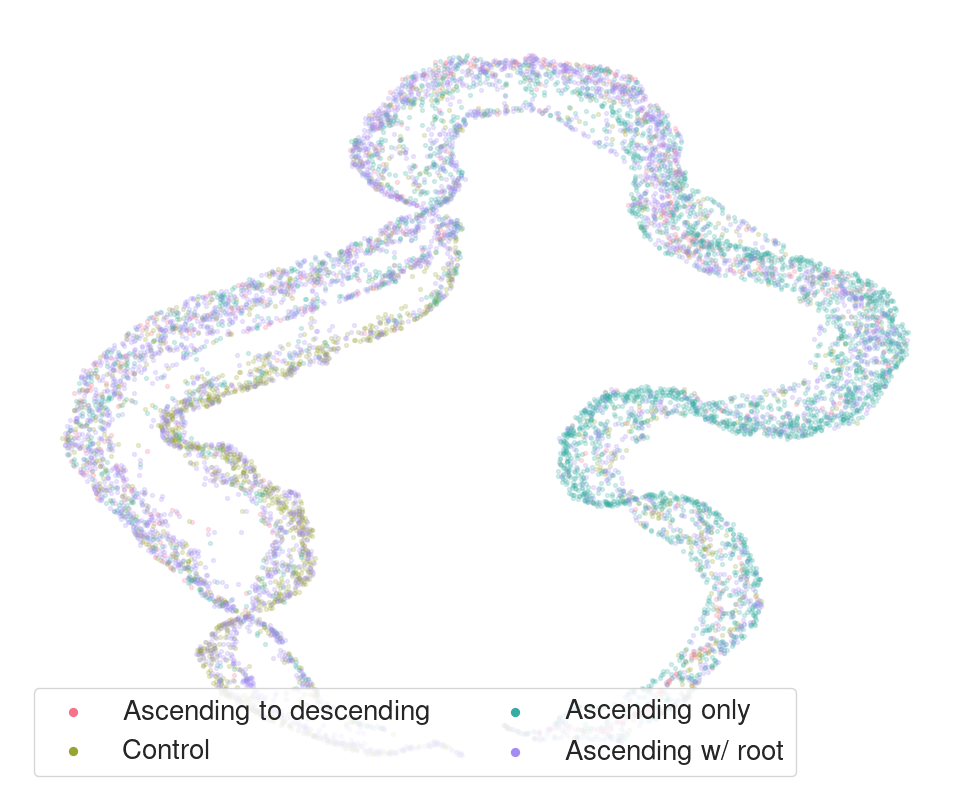

In [104]:
# Assuming sampled_adata.X.A is your input data in the form of a numpy array
# PCA dimension reduction to 50 dimensions
pca = sklearn.decomposition.PCA(n_components=50)
pca_result = pca.fit_transform(sampled_cell_aorta_gpt)
# Compute UMAP on the PCA-reduced data
embedding_sanity_check = umap.UMAP(min_dist=0.5, spread=1).fit_transform(pca_result)
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.phenotype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.phenotype==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.phenotype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
handles = leg.legend_handles if hasattr(leg, "legend_handles") else leg.legendHandles
for lh in handles:
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

([], [])

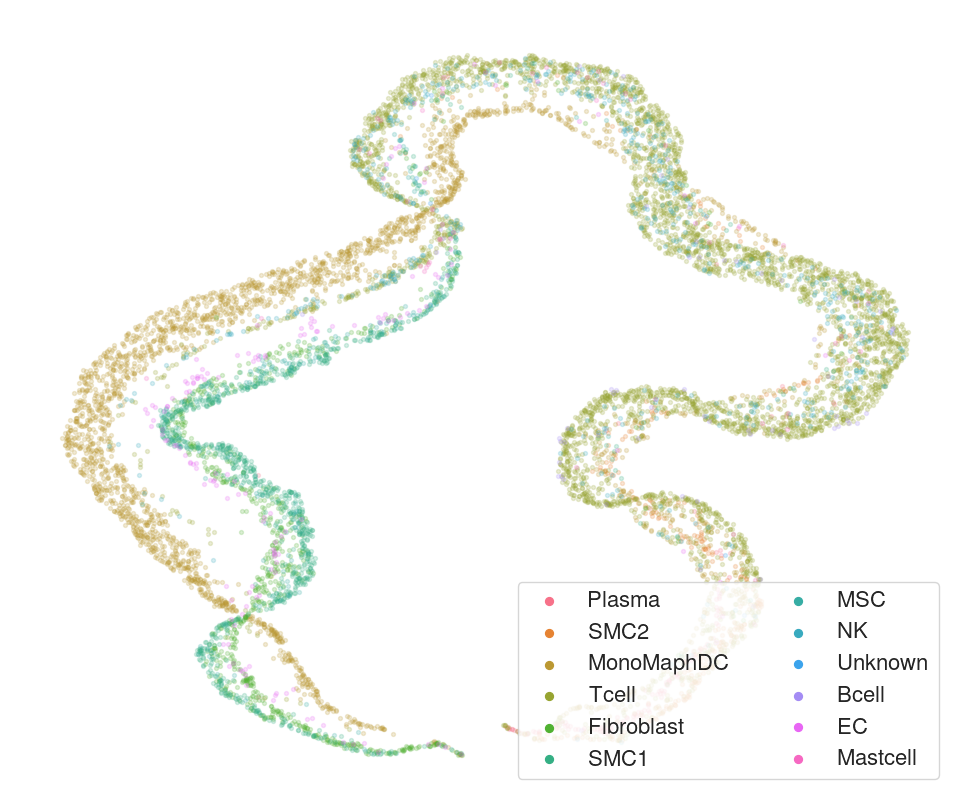

In [105]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.celltype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.celltype==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.celltype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 8},loc='lower right',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
handles = leg.legend_handles if hasattr(leg, "legend_handles") else leg.legendHandles
for lh in handles:
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

([], [])

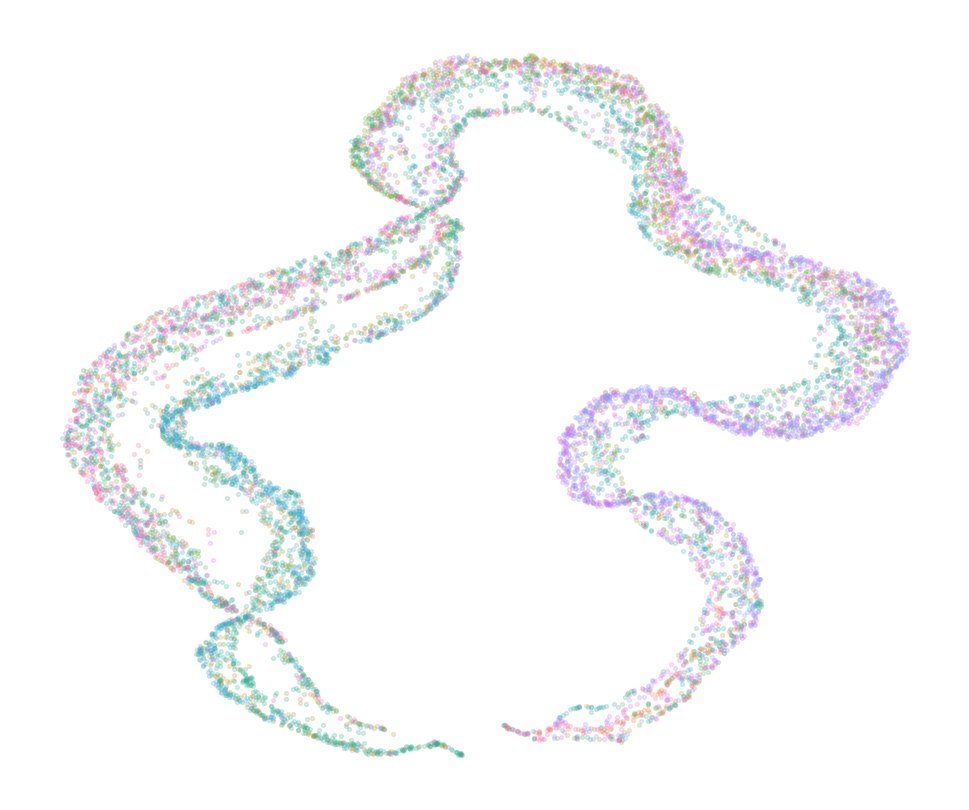

In [106]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.patient)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.patient==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.patient==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
# leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2,bbox_to_anchor=(1.1, 0.10))
plt.rcParams["legend.markerscale"] = 2.0
handles = leg.legend_handles if hasattr(leg, "legend_handles") else leg.legendHandles
for lh in handles:
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

### Add quantitative data to measure the batch effect and the amount of biology encoded in the embeddings

In [107]:
# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(sampled_cell_aorta_gpt, 
                                                    sampled_adata.obs.phenotype,
                                                    test_size=0.20, random_state=2023)

# Verify the split
print(f"Training set size (X_train): {len(X_train)}")
print(f"Test set size (X_test): {len(X_test)}")

Training set size (X_train): 7700
Test set size (X_test): 1925


In [108]:
# oh super high accuracy! interesting... 
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(np.mean(y_test== y_pred_lr))
print(sklearn.metrics.precision_recall_fscore_support(y_test, y_pred_lr, average='weighted'))

/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn

0.5283116883116883
(0.4082779180122517, 0.5283116883116883, 0.46058348425967427, None)


/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Correlate estimated clusters to patient-level effect

In [109]:
kmeans = MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
kmeans.fit(sklearn.decomposition.PCA(n_components=50).fit_transform(X=sampled_cell_aorta_gpt))
annotation_label = sampled_adata.obs.patient
# Getting cluster centers and labels
labels = kmeans.labels_
patient_ari = sklearn.metrics.adjusted_rand_score(labels, annotation_label)
patient_ami = sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label)
print('aRI', patient_ari)
print('aMI', patient_ami)

/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul

aRI 0.07139732776192724
aMI 0.1177754082654494


### Correlate estimated clusters to cell types

In [110]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
kmeans.fit(sampled_cell_aorta_gpt[np.where(sampled_adata.obs.celltype!='Unknown')[0]])
annotation_label = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
# Getting cluster centers and labels
labels = kmeans.labels_
celltype_ari = sklearn.metrics.adjusted_rand_score(labels, annotation_label)
celltype_ami = sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label)
print('aRI', celltype_ari)
print('aMI', celltype_ami)

aRI 0.14839304584176694
aMI 0.2404552014513988


/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/var/folders/xq/l0kcyzrx4yb_nfqlp8frhrxh0000gn/T/ipykernel_39333/3666262404.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annotation_label = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]


### Correlate estimated clusters to phenotypes

In [111]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=4, random_state=2023, batch_size=20)
kmeans.fit(sampled_cell_aorta_gpt)
disease_label = sampled_adata.obs.phenotype
# Getting cluster centers and labels
labels = kmeans.labels_
phenotype_ari = sklearn.metrics.adjusted_rand_score(labels, disease_label)
phenotype_ami = sklearn.metrics.adjusted_mutual_info_score(labels, disease_label)
print('aRI', phenotype_ari)
print('aMI', phenotype_ami)
# print(pd.crosstab(labels, disease_label))

/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


aRI 0.10627006508062212
aMI 0.10118350934210311


## Cell type annotation task
In this block, we demonstrate the performance of GenePT-s and GenePT-w embeddings on cell type annotation tasks in the Aorta dataset. 

In [112]:
# Cross-embedding evaluation (GenePT-w + cross_dna_embeddings)
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

embedding_sources = {
    "genept_w_ada": "./embeddings/GenePT_embedding_v2/GenePT_gene_embedding_ada_text.pickle",
    "cross_concat_evo2_genept": "./embeddings/cross_dna_embeddings/dict_concat_evo2_genept.pkl",
    "cross_evo2_proj": "./embeddings/cross_dna_embeddings/dict_evo2_proj.pkl",
    "cross_genept_proj": "./embeddings/cross_dna_embeddings/dict_genept_proj.pkl",
    "cross_mean_evo2": "./embeddings/cross_dna_embeddings/dict_mean_evo2.pkl",
}

def load_embedding_dict(path: str):
    with open(path, "rb") as fp:
        return pickle.load(fp)

def build_cell_embedding(emb_dict, gene_names, X):
    sample = next(iter(emb_dict.values()))
    embed_dim = np.asarray(sample, dtype=float).flatten().shape[0]
    lookup = np.zeros((len(gene_names), embed_dim))
    missing = 0
    for i, gene in enumerate(gene_names):
        val = emb_dict.get(gene)
        if val is None:
            missing += 1
            continue
        arr = np.asarray(val, dtype=float).flatten()
        if arr.shape[0] != embed_dim:
            raise ValueError(
                f"Unexpected embedding size for {gene}: {arr.shape[0]} (expected {embed_dim})"
            )
        lookup[i, :] = arr
    cell_emb = X @ lookup / len(gene_names)
    return cell_emb, missing, embed_dim

def clustering_metrics(cell_emb):
    patient_labels = sampled_adata.obs.patient
    patient_kmeans = MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
    patient_kmeans.fit(PCA(n_components=50).fit_transform(cell_emb))
    patient_ari = sklearn.metrics.adjusted_rand_score(patient_kmeans.labels_, patient_labels)
    patient_ami = sklearn.metrics.adjusted_mutual_info_score(patient_kmeans.labels_, patient_labels)

    celltype_idx = np.where(sampled_adata.obs.celltype != 'Unknown')[0]
    celltype_labels = sampled_adata.obs.celltype[celltype_idx]
    celltype_kmeans = MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
    celltype_kmeans.fit(cell_emb[celltype_idx])
    celltype_ari = sklearn.metrics.adjusted_rand_score(celltype_kmeans.labels_, celltype_labels)
    celltype_ami = sklearn.metrics.adjusted_mutual_info_score(celltype_kmeans.labels_, celltype_labels)

    phenotype_labels = sampled_adata.obs.phenotype
    phenotype_kmeans = MiniBatchKMeans(n_clusters=4, random_state=2023, batch_size=20)
    phenotype_kmeans.fit(cell_emb)
    phenotype_ari = sklearn.metrics.adjusted_rand_score(phenotype_kmeans.labels_, phenotype_labels)
    phenotype_ami = sklearn.metrics.adjusted_mutual_info_score(phenotype_kmeans.labels_, phenotype_labels)

    return {
        "patient_ari": patient_ari,
        "patient_ami": patient_ami,
        "celltype_ari": celltype_ari,
        "celltype_ami": celltype_ami,
        "phenotype_ari": phenotype_ari,
        "phenotype_ami": phenotype_ami,
    }

def knn_metrics(cell_emb):
    idx = np.where(sampled_adata.obs.celltype != 'Unknown')[0]
    emb = cell_emb[idx]
    labels = np.asarray(sampled_adata.obs.celltype[idx])
    X_train, X_test, y_train, y_test = train_test_split(
        emb, labels, test_size=0.20, random_state=2023
    )
    nn = NearestNeighbors(n_neighbors=10, metric='cosine')
    nn.fit(X_train)
    neighbors = nn.kneighbors(X_test, return_distance=False)
    preds = [Counter(y_train[n]).most_common(1)[0][0] for n in neighbors]
    acc = sklearn.metrics.accuracy_score(y_test, preds)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_test, preds, average='macro'
    )
    return acc, prec, rec, f1

rows = []

for name, path in embedding_sources.items():
    emb_dict = load_embedding_dict(path)
    cell_emb, missing, embed_dim = build_cell_embedding(emb_dict, gene_names, sampled_adata.X)
    cluster = clustering_metrics(cell_emb)
    acc, prec, rec, f1 = knn_metrics(cell_emb)

    rows.append({
        "name": name,
        "embed_dim": embed_dim,
        "missing_genes": f"{missing}/{len(gene_names)}",
        "celltype_ari": cluster["celltype_ari"],
        "celltype_ami": cluster["celltype_ami"],
        "phenotype_ari": cluster["phenotype_ari"],
        "phenotype_ami": cluster["phenotype_ami"],
        "patient_ari": cluster["patient_ari"],
        "patient_ami": cluster["patient_ami"],
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    })

# Literature reference row for GenePT-w (Aorta, Table T6)
rows.append({
    "name": "genept_w_literature",
    "embed_dim": "NA",
    "missing_genes": "NA",
    "celltype_ari": 0.54,
    "celltype_ami": 0.60,
    "phenotype_ari": 0.09,
    "phenotype_ami": 0.12,
    "patient_ari": "NA",
    "patient_ami": "NA",
    "accuracy": 0.88,
    "precision": 0.91,
    "recall": 0.68,
    "f1": 0.72,
})

# Order: literature, recreated GenePT-w, then cross embeddings
row_map = {row["name"]: row for row in rows}
ordered_names = [
    "genept_w_literature",
    "genept_w_ada",
    "cross_concat_evo2_genept",
    "cross_evo2_proj",
    "cross_genept_proj",
    "cross_mean_evo2",
]
rows = [row_map[name] for name in ordered_names if name in row_map]

headers = [
    "name",
    "accuracy", "precision", "recall", "f1",
    "celltype_ari", "celltype_ami",
    "phenotype_ari", "phenotype_ami",
    "patient_ari", "patient_ami",
    "embed_dim", "missing_genes",
]

def fmt(v):
    if isinstance(v, float):
        return f"{v:.3f}"
    return str(v)

md_lines = [
    "| " + " | ".join(headers) + " |",
    "| " + " | ".join(["---"] * len(headers)) + " |",
]
for row in rows:
    md_lines.append("| " + " | ".join(fmt(row[h]) for h in headers) + " |")

csv_lines = [",".join(headers)]
for row in rows:
    csv_lines.append(",".join(fmt(row[h]) for h in headers))

md_text = "\n".join(md_lines)

Path("benchmarks/outputs/aorta_cross/aorta_results_cross.md").write_text(md_text)
Path("benchmarks/outputs/aorta_cross/aorta_results_cross.txt").write_text(md_text)
Path("benchmarks/outputs/aorta_cross/aorta_results_cross.csv").write_text("\n".join(csv_lines))

print("Wrote results to benchmarks/outputs/aorta_cross/...")

/var/folders/xq/l0kcyzrx4yb_nfqlp8frhrxh0000gn/T/ipykernel_39333/3757050982.py:34: RuntimeWarning: divide by zero encountered in matmul
  cell_emb = X @ lookup / len(gene_names)
/var/folders/xq/l0kcyzrx4yb_nfqlp8frhrxh0000gn/T/ipykernel_39333/3757050982.py:34: RuntimeWarning: overflow encountered in matmul
  cell_emb = X @ lookup / len(gene_names)
/var/folders/xq/l0kcyzrx4yb_nfqlp8frhrxh0000gn/T/ipykernel_39333/3757050982.py:34: RuntimeWarning: invalid value encountered in matmul
  cell_emb = X @ lookup / len(gene_names)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountere

Wrote results to aorta_results_cross.md/.txt/.csv


/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrewrusli/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [113]:
with open("./embeddings/GenePT_embedding_v2/GenePT_gene_embedding_ada_text.pickle", "rb") as fp:
    GPT_3_5_gene_embeddings = pickle.load(fp)
gene_names= list(sampled_adata.var.index)
count_missing = 0
EMBED_DIM = 1536 # embedding dim from GPT-3.5
lookup_embed = np.zeros(shape=(len(gene_names),EMBED_DIM))
for i, gene in enumerate(gene_names):
    if gene in GPT_3_5_gene_embeddings:
        embed = np.asarray(GPT_3_5_gene_embeddings[gene], dtype=float).flatten()
        if embed.shape[0] != EMBED_DIM:
            raise ValueError(
                f"Unexpected embedding size for {gene}: {embed.shape[0]} (expected {EMBED_DIM})"
            )
        lookup_embed[i,:] = embed
    else:
        count_missing+=1
missing_count = count_missing
genePT_w_emebed = np.dot(sampled_adata.X,lookup_embed)/len(gene_names)
print(f"Unable to match {missing_count} out of {len(gene_names)} genes in the GenePT-w embedding")

Unable to match 5344 out of 23331 genes in the GenePT-w embedding


### We split the Aorta dataset with annotated cell types into 80%/20% train/test split and perform a 10-nearest-neighbor classifier. 
Code credit: the set up for the 10-NN classifier was ported from the scGPT authors at https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb

#### First for GenePT-w emebddings

In [114]:
# Split the data into training and test sets (80/20)
genePT_w_emebed = genePT_w_emebed[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
genePT_w_emebed_train, genePT_w_emebed_test, y_train, y_test = train_test_split(genePT_w_emebed, 
                                                    y_celltype_remove_unknown,
                                                    test_size=0.20, random_state=2023)

# ensure numpy arrays for indexing
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

/var/folders/xq/l0kcyzrx4yb_nfqlp8frhrxh0000gn/T/ipykernel_39333/4285832206.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]


In [115]:
# cell type clustering
# very quick test
k = 10  # number of neighbors
ref_cell_embeddings = genePT_w_emebed_train
test_emebd = genePT_w_emebed_test
neighbors_list_gpt_v1 = []
if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'cosine', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    # this is the true cell type
    gt = y_test[k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = Counter(y_train[idx]).most_common(1)[0][0]
    neighbors_list_gpt_v1.append(y_train[idx])
    gt_list.append(gt)
    pred_list.append(pred)

geneptw_celltype_accuracy = sklearn.metrics.accuracy_score(gt_list, pred_list)
print(geneptw_celltype_accuracy)

0.87467498699948


In [116]:
geneptw_precision, geneptw_recall, geneptw_f1, _ = sklearn.metrics.precision_recall_fscore_support(
    gt_list, pred_list, average='macro'
)
print('Precision, Recall, F1 (Marco weighted) for GenePT-w embedding: ', \
      (geneptw_precision, geneptw_recall, geneptw_f1, None))


Precision, Recall, F1 (Marco weighted) for GenePT-w embedding:  (0.8982445800013106, 0.6862957649154828, 0.7332265295188166, None)


#### Cross-embedding kNN comparison (no GenePT-s)

In [117]:
# Split the data into training and test sets (80/20)
genePT_s_emebed = sampled_cell_aorta_gpt[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
genePT_s_emebed_train, genePT_s_emebed_test, y_train, y_test = train_test_split(genePT_w_emebed, 
                                                    y_celltype_remove_unknown,
                                                    test_size=0.20, random_state=2023)

# ensure numpy arrays for indexing
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

/var/folders/xq/l0kcyzrx4yb_nfqlp8frhrxh0000gn/T/ipykernel_39333/3088775809.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]


In [118]:
# cell type clustering
# very quick test
k = 10  # number of neighbors
ref_cell_embeddings = genePT_s_emebed_train
test_emebd = genePT_s_emebed_test
neighbors_list_gpt_v2 = []
if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'cosine', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    # this is the true cell type
    gt = y_test[k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = Counter(y_train[idx]).most_common(1)[0][0]
    neighbors_list_gpt_v2.append(y_train[idx])
    gt_list.append(gt)
    pred_list.append(pred)
sklearn.metrics.accuracy_score(gt_list, pred_list)

0.87467498699948

In [119]:
from pathlib import Path

results_path = Path("aorta_results.txt")
results_text = "\n".join([
    "Aorta analysis results (GenePT-w used for embeddings)",
    f"Missing genes in GenePT-w embedding: {missing_count} / {len(gene_names)}",
    "",
    f"Cell-type clustering (aRI, aMI): {celltype_ari}, {celltype_ami}",
    f"Phenotype clustering (aRI, aMI): {phenotype_ari}, {phenotype_ami}",
    f"Patient clustering (aRI, aMI): {patient_ari}, {patient_ami}",
    "",
    "Cell-type annotation (macro)",
    f"Accuracy: {geneptw_celltype_accuracy}",
    f"Precision: {geneptw_precision}",
    f"Recall: {geneptw_recall}",
    f"F1: {geneptw_f1}",
])

results_path.write_text(results_text)
print(f"Wrote results to {results_path}")

Wrote results to aorta_results.txt
